Import libraries and clean 

In [130]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns;

In [4]:
df = pd.read_csv('data/Seasons_Stats.csv')
print(df.shape)

(24691, 53)


In [5]:
def filter_years(df):
    # Filter data so only seasons from 2010 onwards are included
    df = df[df['Year'].notna()]
    df = df[df['Year'] >= 2010]
    df['Year'] = df['Year'].astype(int)
    return df

def cleaned_df(df):
    # Clean dataframe so only 1 season stat is included for every player per season
    years = df['Year'].unique()
    for year in years:
        df_year = df[df['Year'] == year]
        df_year = df_year[df_year.duplicated(subset='Player', keep=False)]
        common_rows = df['Unnamed: 0'].isin(df_year['Unnamed: 0'])
        df.drop(df[common_rows].index, inplace = True)
        df = df.append(df_year[df_year['Tm'] == 'TOT'])
    return df

def fill_empty_values(df):
    # Remove unneccesary columns and fill nulls with 0
    df.drop(columns=['Unnamed: 0', 'blanl', 'blank2'], inplace=True)
    df.drop(df[df['USG%'].isnull()].index, inplace=True)
    df.fillna(0, inplace=True)
    return df

In [6]:
df = filter_years(df)
df = cleaned_df(df)
df = fill_empty_values(df)
df.shape

(3771, 50)

In [7]:
# Taking only first position listed when multiple are listed
df['Pos'] = df['Pos'].str.split('-').str[0]

Visualize

In [8]:
features = [x for x in df.columns if (x != 'Player') &  (x != 'Pos')]
print(df.shape)
print(features)

(3771, 50)
['Year', 'Age', 'Tm', 'G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']


In [9]:
def df_PCA_yr(df, year):
    df_vis = df[df['Year'] == year]
    df_vis = df_vis.drop('Year', axis=1)
    features = [x for x in df_vis.columns if (x != 'Player') &  (x != 'Pos') & (x != 'Tm')]
    x = df_vis.loc[:, features].values
    y = df_vis.loc[:,['Pos']].values
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
    final = pd.concat([principalDf.reset_index(drop=True), df_vis['Pos'].reset_index(drop=True)], axis=1)
    print("Explained variance: ", pca.explained_variance_ratio_)
    return final,pca,features

def plot_PCA(df_PCA):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)

    targets = df_PCA.Pos.unique() # list of positions (PCA groups)
    colors = ['r', 'g', 'b', 'm', 'c']
    for target, color in zip(targets,colors):
        indicesToKeep = df_PCA['Pos'] == target
        ax.scatter(df_PCA.loc[indicesToKeep, 'pc1']
                , df_PCA.loc[indicesToKeep, 'pc2']
                , c = color
                , s = 50)
    ax.legend(targets)
    ax.grid()
    return None

def plot_featImport_PCA(pcaObj, features):
     # feature importance for first dimension
    fimp1 = pd.DataFrame(data={'feat':features,'imp':pcaObj.components_[0]})
    fimp1 = fimp1.reindex(fimp1.imp.abs().sort_values(ascending = False).index)
    # print(fimp1)
    top_fimp1 = fimp1.nlargest(10,'imp')
    top_fimp1 = top_fimp1.iloc[::-1]
    top_fimp1 = top_fimp1.set_index("feat")
    ax = top_fimp1.plot.barh()
    ax.set_xlabel('Importance', fontsize = 15)
    ax.set_ylabel('Feature', fontsize = 15)
    ax.set_title('PCA Component 1 Feature Importance', fontsize = 20)

    # repeat for second dimension
    fimp2 = pd.DataFrame(data={'feat':features,'imp':pcaObj.components_[1]})
    fimp2 = fimp2.reindex(fimp2.imp.abs().sort_values(ascending = False).index)
    top_fimp2 = fimp2.nlargest(10,'imp')
    top_fimp2 = top_fimp2.iloc[::-1]
    top_fimp2 = top_fimp2.set_index("feat")
    ax = top_fimp2.plot.barh()
    ax.set_xlabel('Importance', fontsize = 15)
    ax.set_ylabel('Feature', fontsize = 15)
    ax.set_title('PCA Component 2 Feature Importance', fontsize = 20)

Explained variance:  [0.43195393 0.16785902]


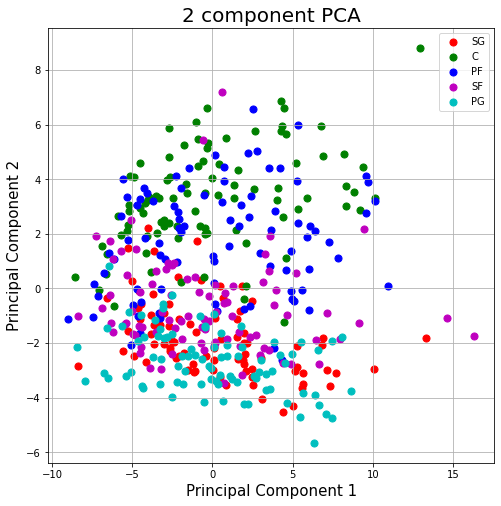

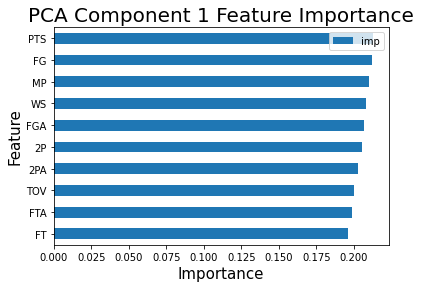

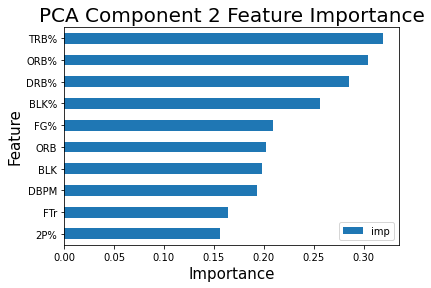

In [10]:
df_PCA, pca, features = df_PCA_yr(df, 2010)
plot_PCA(df_PCA)
plot_featImport_PCA(pca, features)

# K-Means Clustering

### Note: You may need to re-run the second block of code (reading the .csv) AND the data cleaning block before running everything after this point.

In [101]:
year = 2015
season_data = df[df['Year'] == year]
season_data = season_data.drop('Year', axis=1)

#Mean value of every column
season_data.mean()

#Mean value of specified column
season_data.loc[:,"FG"].mean()

187.5752032520325

### Create a pairplot and a heatmap in order to see correlations between different columns

In [134]:
def plot_pairwise_scatter(dataframe, columns):
    sns.pairplot(dataframe[[columns[0], columns[1], columns[2]]])
    plt.show()
    
def plot_correlation_heatmap(dataframe, columns):
    correlation = season_data[[columns[0], columns[1], columns[2]]].corr()
    sns.heatmap(correlation, annot=True)
    
def get_numeric_data_only(dataframe):
    return dataframe._get_numeric_data().dropna(axis=1)

def get_PCA_with_clusters(dataframe):
    columns_with_numeric_data = get_numeric_data_only(dataframe)
    nba_pca = PCA(2) #put data into 2 dimensions
    return nba_pca.fit_transform(columns_with_numeric_data)
    
def plot_PCA_with_clusters(dataframe, data_labels, model):
    plot_columns = get_PCA_with_clusters(dataframe)   
    pred_y = model.fit_predict(plot_columns)
    plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model.labels_)
    plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1],
           s=30, c='blue')
    plt.show()
    
def generate_kmeans_model(dataframe, k):
    model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    columns_with_numeric_data = get_numeric_data_only(dataframe)
    model.fit(columns_with_numeric_data)
    return model
    
def get_kmeans_cluster_labels(kmeans_model):
    return kmeans_model.labels_

def get_player_label(dataframe, player_name, model):
    columns_with_numeric_data = get_numeric_data_only(dataframe)
    player = columns_with_numeric_data.loc[season_data['Player'] == player_name,:]
    player_list = player.values.tolist()
    player_label = model.predict(player_list)
    return player_label

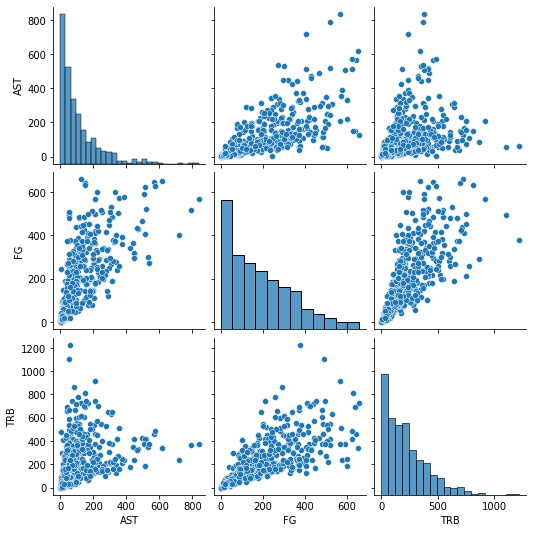

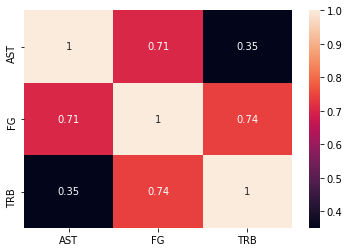

In [103]:
columns = ["AST", "FG", "TRB"]
plot_pairwise_scatter(season_data, columns)
plot_correlation_heatmap(season_data, columns)

### Use the K-Means Clustering Method to see which players are the most similar

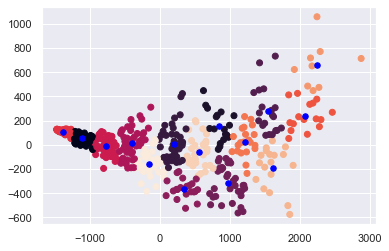

In [140]:
kmeans_model = generate_kmeans_model(season_data, 15)
labels = get_kmeans_cluster_labels(kmeans_model)
plot_PCA_with_clusters(season_data, labels, kmeans_model)

### See which cluster a specific player belongs to

In [105]:
player_one_label = get_player_label(season_data, 'LeBron James', kmeans_model)
print(player_one_label)

[2]


### The Elbow Method for Finding Optimal K-Value

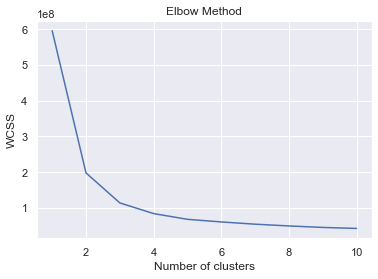

In [145]:
wcss = []

for i in range(1, 11):
    k_means = KMeans(n_clusters=i, init='k-means++', max_iter=300,
                    n_init=10, random_state=0)
    #plot_columns = get_PCA_with_clusters(season_data)   
    #pred_y = model.fit_predict(plot_columns)
    #k_means.fit_predict(plot_columns)
    k_means.fit(get_numeric_data_only(season_data))
    wcss.append(k_means.inertia_)

plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Split data into 80% training and 20% testing for the columns you want to use. The first column is the data you will be using to predict the value of the second column

In [16]:
x_train, x_test, y_train, y_test = train_test_split(season_data[["FG"]], season_data[["AST"]], test_size=0.2, random_state=42)

linear_regression = LinearRegression()
linear_regression.fit(x_train, y_train)
predictions = linear_regression.predict(x_test)

# This function returns the coefficient of determination R^2 of the prediction. 1.0 is the best possible score
# In this example, with FG and AST. The lin_reg_confidence (i.e. 0.44) means that 44% of the variance for AST values are
# explained by field goals. Model is not very good rn
lin_reg_confidence = linear_regression.score(x_test, y_test)
print("Linear Regression confidence (R^2): ", lin_reg_confidence)
print("Mean Squared Error: ", mean_squared_error(y_test, predictions))


Linear Regression confidence (R^2):  0.5175289279764579
Mean Squared Error:  5431.295013949916
